This is final project for the course "Machine Learining in Graphs"

In [3]:
import pandas as pd
import networkx as nx
from consts import *
from build_graph import build_bi_partite_graph

import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from matplotlib_venn import venn2
from tqdm.auto import tqdm

import data_utils
import graph_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [4]:
train_data = pd.read_csv("2021_Q1.csv")
train_data = pd.concat([train_data, pd.read_csv("2021_Q2.csv")])
train_data = pd.concat([train_data, pd.read_csv("2021_Q3.csv")])
validation_data = pd.read_csv("2021_Q4.csv")

In [5]:
print(f"Train data: {train_data.shape}")
print(f"Validation data: {validation_data.shape}")

Train data: (11038687, 3)
Validation data: (3005511, 3)


In [6]:
graph = build_bi_partite_graph(train_data, DRUG, REACTION)
print(graph)
nx.write_graphml(graph, "graph1.graphml")

validation_graph = build_bi_partite_graph(validation_data, DRUG, REACTION)


Building graph:   0%|          | 0/11038687 [00:00<?, ?it/s]

Graph with 62696 nodes and 1866087 edges


Building graph:   0%|          | 0/3005511 [00:00<?, ?it/s]

<Axes: xlabel='log(degree)', ylabel='log(Count)'>

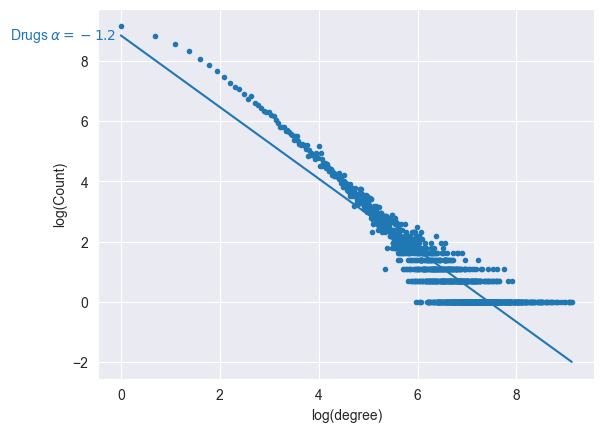

In [7]:
data_utils.plot_degree_distribiution(graph, "Drugs")

In [ ]:
# Extract edges from both graphs
# edges_in_graph = set(graph.edges())
# edges_in_validation_graph = set(validation_graph.edges())
# 
# # Find new edges in validation_graph that are not in graph
# new_edges = edges_in_validation_graph - edges_in_graph
# print(f"Number of new edges: {len(new_edges)}")
# # convert to a pandas DataFrame
# new_edges = pd.Series(list(new_edges))
# # create bi pirate graph from new edges
# validation_graph = build_bi_partite_graph(validation_data, DRUG, REACTION)
new_edges = validation_graph[ (validation_graph[DRUG], validation_graph[REACTION]) not in graph.edges()  ]



In [ ]:
edges_with_attributes = graph.edges(data=True)
sorted_edges = sorted(edges_with_attributes, key=lambda x: x[2]['weight'], reverse=True)
top_edges = sorted_edges[:500]
new_graph = nx.Graph()
new_graph.add_edges_from(top_edges)

layout = nx.spring_layout(new_graph, weight="weight")
nx.draw(new_graph, layout, node_size=30,
        with_labels=True,
        font_size=8)
nx.write_graphml(new_graph, "graph3.graphml")

In [ ]:
data = []
for _ in range(10000):
    u = np.random.choice(graph.nodes)
    v = np.random.choice(graph.nodes)
    has_edge = graph.has_edge(u, v)
    jaccard_coefficient = nx.jaccard_coefficient(graph, [(u, v)])
    adamic_adar_index = nx.adamic_adar_index(graph, [(u, v)])
    preferential_attachment = nx.preferential_attachment(graph, [(u, v)])
    common_neighbors = nx.common_neighbors(graph, u, v)
    resource_allocation_index = nx.resource_allocation_index(graph, [(u, v)])
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "jaccard_coefficient",
            "metric_value": list(jaccard_coefficient)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "adamic_adar_index",
            "metric_value": list(adamic_adar_index)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "preferential_attachment",
            "metric_value": list(preferential_attachment)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "common_neighbors",
            "metric_value": len(list(common_neighbors)),
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "resource_allocation_index",
            "metric_value": list(resource_allocation_index)[0][-1],
        }
    )

df_metrics = pd.DataFrame(data)
df_metrics

In [ ]:
df_x = df_metrics.pivot_table(
    index=["u", "v"], columns="metric_name", values="metric_value"
).reset_index()
df_x

In [ ]:


X = df_x.drop(columns=["u", "v"])
y = np.array(
    [
        graph.has_edge(row.u, row.v)
        for _, row in df_x.iterrows()
    ]
)
weight = np.array([1 if has_edge else 0.05 for has_edge in y])
y

In [ ]:
X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.2, random_state=42
)
# Check for data leakage
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Inspect the first few rows of the training data
print(X_train.head())
print(y_train[:5])


In [ ]:
%matplotlib inline
model = CatBoostClassifier(
    n_estimators=500,
    learning_rate=0.001,
    depth=12,
    eval_metric="AUC",
    loss_function="Logloss",
    l2_leaf_reg=4,
    verbose=False,
)
model.fit(
    X_train,
    y_train,
    sample_weight=weight_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=150,
    plot=True,
    verbose=True,
)

In [ ]:
feature_importance = (
    pd.DataFrame(
        model.get_feature_importance(), index=X.columns, columns=["importance"]
    )
    .sort_values("importance", ascending=True)
    .tail(30)
)
feature_importance.plot(kind="barh", title="Feature importance")

The node XOLAIR has 215 new neighbors.
Reactions len: 8674


Processing reaction nodes:   0%|          | 0/8674 [00:00<?, ?it/s]

Running prediction:
Predicted: 8674


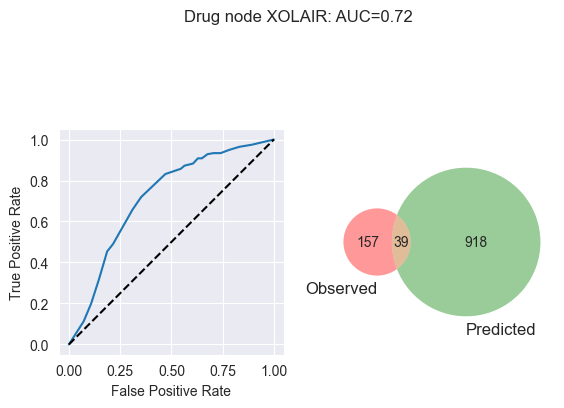

In [73]:
# new_edges = validation_graph[ (validation_graph[DRUG], validation_graph[REACTION]) not in graph.edges() ]

# Extract edges from both graphs
edges_in_graph = set(graph.edges())
edges_in_validation_graph = set(validation_graph.edges())

# Find new edges in validation_graph that are not in graph
new_edges = edges_in_validation_graph - edges_in_graph

# Convert the set of new edges to a DataFrame
new_edges = pd.DataFrame(list(new_edges), columns=[DRUG, REACTION])


def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")
    
    if not n_added:
        return
    
    to_predict_x = []
    to_predict_y = []
    
    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue
        
        u, v = (target, drug)
        
        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])
        
        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })
        
        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )
        # print(f"Added edge: {u}, {v}")
    
    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")
    
    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )
    
    fig.suptitle(f"Drug node {drug}: AUC={roc_auc:.2f}")
    plt.show()
    
check_prediction("XOLAIR", new_edges, graph)

The node XOLAIR has 215 new neighbors.
Reactions len: 8674


Processing reaction nodes:   0%|          | 0/8674 [00:00<?, ?it/s]

Running prediction:
Predicted: 7900


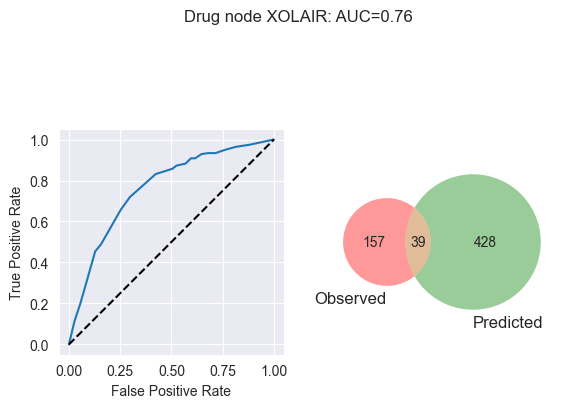

In [74]:
# new_edges = validation_graph[ (validation_graph[DRUG], validation_graph[REACTION]) not in graph.edges() ]

# Extract edges from both graphs
edges_in_graph = set(graph.edges())
edges_in_validation_graph = set(validation_graph.edges())

# Find new edges in validation_graph that are not in graph
new_edges = edges_in_validation_graph - edges_in_graph

# Convert the set of new edges to a DataFrame
new_edges = pd.DataFrame(list(new_edges), columns=[DRUG, REACTION])


def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")
    
    if not n_added:
        return
    
    to_predict_x = []
    to_predict_y = []
    
    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue
            
        if graph_before.has_edge(target, drug):
            continue
        
        u, v = (target, drug)
        
        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])
        
        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })
        
        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )
        # print(f"Added edge: {u}, {v}")
    
    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")
    
    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )
    
    fig.suptitle(f"Drug node {drug}: AUC={roc_auc:.2f}")
    plt.show()
    
check_prediction("XOLAIR", new_edges, graph)